In [1]:
import nbimporter
import myai as ai

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
Data = pd.read_excel('price feature 5 timestep target 1 timestep.xlsx')

In [3]:
Data

,h5,l5,h4,l4,h3,l3,h2,l2,h1,l1,target
0,1.146279,1.146059,1.146062,1.145776,1.146468,1.146288,1.146666,1.146576,1.146509,1.146392,1.146159
1,1.146062,1.145776,1.146468,1.146288,1.146666,1.146576,1.146509,1.146392,1.146159,1.145967,1.145842
2,1.146468,1.146288,1.146666,1.146576,1.146509,1.146392,1.146159,1.145967,1.145842,1.145704,1.145568
3,1.146666,1.146576,1.146509,1.146392,1.146159,1.145967,1.145842,1.145704,1.145568,1.145446,1.145330
4,1.146509,1.146392,1.146159,1.145967,1.145842,1.145704,1.145568,1.145446,1.145330,1.145190,1.145338
...,...,...,...,...,...,...,...,...,...,...,...
32182,1.105398,1.105328,1.105536,1.105455,1.105527,1.105431,1.105530,1.105465,1.105427,1.105365,1.105384
32183,1.105536,1.105455,1.105527,1.105431,1.105530,1.105465,1.105427,1.105365,1.105384,1.105288,1.105475
32184,1.105527,1.105431,1.105530,1.105465,1.105427,1.105365,1.105384,1.105288,1.105475,1.105418,1.105417
32185,1.105530,1.105465,1.105427,1.105365,1.105384,1.105288,1.105475,1.105418,1.105417,1.105367,1.105335


### 1.1 change dataframe to matrix

In [4]:
DataMatrix = Data.values

In [5]:
np.random.shuffle(DataMatrix)

### 1.2 split matrix to X and Y

In [6]:
N = DataMatrix.shape[0]

In [7]:
D = DataMatrix.shape[1] - 1

In [8]:
X = DataMatrix[:, :D]
Y = DataMatrix[:, D:]

### 1.3 split data to training set and test set

In [9]:
start = 0
end = int(0.8*N)

In [10]:
X_train = np.array(X[start:end, :], dtype='float32')
Y_train = np.array(Y[start:end, :], dtype='float32')

X_test = np.array(X[end:, :], dtype='float32')
Y_test = np.array(Y[end:, :], dtype='float32')

### 1.4 normalize X and Y

In [11]:
norm_X = ai.Normalize(X_train, norm_type='minmaxNorm')
norm_Y = ai.Normalize(Y_train, norm_type='minmaxNorm')

In [12]:
X_train_norm = norm_X.fit(X_train)
Y_train_norm = norm_Y.fit(Y_train)

In [13]:
X_test_norm = norm_X.fit(X_test)
Y_test_norm = norm_Y.fit(Y_test)

## 2. Create Model

### 2.1 learn

In [15]:
regr = ai.LSTM(n_ts_feature=5, n_ts_target=1, RNN_HL=[3], ANN_HL=[2, 1], ANN_AF=['sigmoid', ['prelu', 0.5]])

In [16]:
regr.fit(X_train_norm, Y_train_norm, 'mse', epoch=200, learning_rate=0.05)

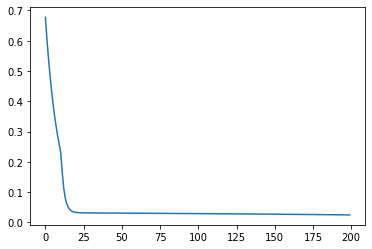

In [17]:
plt.plot(regr.loss_list)

### 2.2 model evaluation for training set

In [18]:
Yhat_train_norm = regr.predict(X_train_norm)

In [19]:
Yhat_train_norm

In [20]:
n_rows_yhat_train = Yhat_train_norm[0].data.shape[0]
_Yhat_train_norm = np.empty([n_rows_yhat_train, 0], dtype=float)
for i in range(regr.n_ts_target):
    _Yhat_train_norm = np.hstack([_Yhat_train_norm, Yhat_train_norm[i].data])

In [21]:
Yhat_train = norm_Y.transform(_Yhat_train_norm)

In [22]:
Yhat_train_TS = ai.RNN.seperate_timestep(Yhat_train, regr.n_ts_target)

In [23]:
Yhat_train_TS

[array([[1.11692462],
        [1.11998697],
        [1.12213995],
        ...,
        [1.12200769],
        [1.12171558],
        [1.10877577]])]

In [24]:
Y_train_TS = ai.RNN.seperate_timestep(Y_train, regr.n_ts_target)

In [25]:
Y_train_TS

[array([[1.108083],
        [1.119959],
        [1.139595],
        ...,
        [1.137795],
        [1.134687],
        [1.093868]], dtype=float32)]

In [26]:
for i in range(regr.n_ts_target):
    print('timestep :', i+1)
    print(ai.ErrorScore.find_error(Y_train_TS[i], Yhat_train_TS[i], 'MSE'))

timestep : 1
0.00011726047012616192


timestep : 1


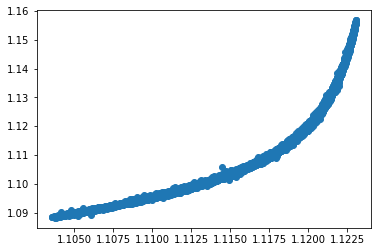

In [27]:
for i in range(regr.n_ts_target):
    print('timestep :', i+1)
    plt.scatter(Yhat_train_TS[i], Y_train_TS[i])
    plt.plot()

## 3. Making Prediction

### 3.1 Predict

In [28]:
Yhat_test_norm = regr.predict(X_test_norm)

In [29]:
n_rows_yhat_test = Yhat_test_norm[0].data.shape[0]
_Yhat_test_norm = np.empty([n_rows_yhat_test, 0], dtype=float)
for i in range(regr.n_ts_target):
    _Yhat_test_norm = np.hstack([_Yhat_test_norm, Yhat_test_norm[i].data])

In [30]:
Yhat_test = norm_Y.transform(_Yhat_test_norm)

In [31]:
Yhat_test_TS = ai.RNN.seperate_timestep(Yhat_test, regr.n_ts_target)

### 3.2 model evaluation for test set

In [32]:
Y_test_TS = ai.RNN.seperate_timestep(Y_test, regr.n_ts_target)

In [33]:
for i in range(regr.n_ts_target):
    print('timestep :', i+1)
    print(ai.ErrorScore.find_error(Y_test_TS[i], Yhat_test_TS[i], 'MSE'))

timestep : 1
0.00011892923283074165


timestep : 1


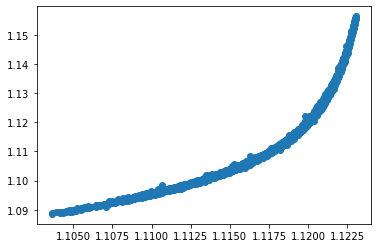

In [34]:
for i in range(regr.n_ts_target):
    print('timestep :', i+1)
    plt.scatter(Yhat_test_TS[i], Y_test_TS[i])
    plt.plot()